House Price Predictions - Regresion

Modules

#### Data Manipulation & Feature Engineering

In [2]:
data = pd.read_csv('../Data/train.csv')
data.drop(columns='Id', inplace=True)
data.shape

(1460, 80)

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

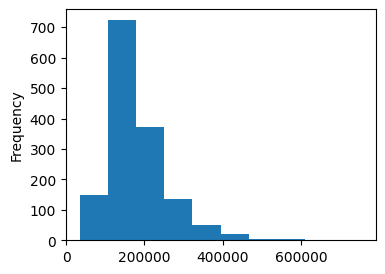

In [3]:
# Target
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

count    1460.000000
mean       12.024051
std         0.399452
min        10.460242
25%        11.775097
50%        12.001505
75%        12.273731
max        13.534473
Name: SalePrice, dtype: float64

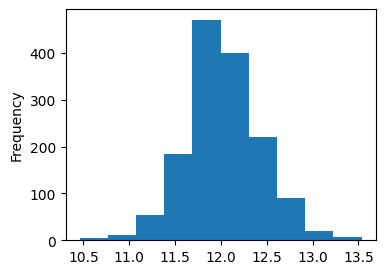

In [4]:
data.SalePrice = np.log(data.SalePrice)
data.SalePrice.plot.hist(figsize = (4,3))
data.SalePrice.describe()

Missing values

In [5]:
data.isna().sum().sort_values(ascending=False)[:13]#/data.shape[0]*100

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
MasVnrType       872
                ... 
GarageType        81
GarageFinish      81
GarageCond        81
GarageYrBlt       81
BsmtExposure      38
Length: 13, dtype: int64

In [6]:
quality = {'Ex':5,'Gd': 4,'TA': 3,'Fa': 2,'Po': 1, 'No': 0}

# Pool1QC
data.PoolQC[~data.PoolQC.isna()] = 'Yes'
data.PoolQC.fillna('No', inplace=True)
#data.groupby('PoolQC')['SalePrice'].mean()

# MiscFeature
data.MiscFeature[~data.MiscFeature.isna()] = 'Yes'
data.MiscFeature.fillna('No', inplace=True)
#data.groupby('MiscFeature')['SalePrice'].mean()

# Alley
data.Alley[data.Alley.isna()] = 'No alley access'
#data.groupby('Alley')['SalePrice'].mean()

# Fence
data.Fence[~data.Fence.isna()] = 'Yes'
data.Fence.fillna('No', inplace=True)
#data.groupby('Fence')['SalePrice'].mean()

# MasVnrType
data.MasVnrType.fillna('Not Reported', inplace=True)
#data.groupby('MasVnrType')['SalePrice'].mean()

# FireplaceQu
#data.FireplaceQu[~data.FireplaceQu.isna()] = 'Yes'
data.FireplaceQu.fillna('No', inplace=True)
#data.FireplaceQu = data.FireplaceQu.map(quality)
#data.groupby('FireplaceQu')['SalePrice'].mean()

# LotFrontage
lotshape_medians = data.groupby("LotShape")["LotFrontage"].median()
data["LotFrontage"] = data["LotFrontage"].fillna(data["LotShape"].map(lotshape_medians))

# GarageQual
data.GarageQual.fillna('No', inplace=True)
#data.GarageQual = data.GarageQual.map(quality)
#data.groupby('GarageQual')['SalePrice'].mean()

# Garage
data.GarageFinish.fillna('No Garage', inplace=True)
data.GarageType.fillna('No Garage', inplace=True)
data.GarageCond.fillna('No', inplace=True)

# Basement
data.BsmtExposure.fillna('No Bsmnt', inplace=True)
data.BsmtFinType2.fillna('No Bsmnt', inplace=True)
data.BsmtFinType1.fillna('No Bsmnt', inplace=True)
data.BsmtCond.fillna('No', inplace=True)
data.BsmtQual.fillna('No', inplace=True)

# MasVnrArea
data.MasVnrArea.fillna(data.MasVnrArea.median(skipna=True), inplace=True)

# Electrical
data.Electrical.fillna(data.Electrical.mode().values[0], inplace = True)

New Features

In [7]:
# Building Age
data['BuildingAge'] = data.YearBuilt.max(skipna=True) - data.YearBuilt + 1
data['Remodeling'] = (data['YearBuilt'] != data['YearRemodAdd'])

# Garage Age
data['GarageYrBlt'] = data.GarageYrBlt.max(skipna=True) - data.GarageYrBlt + 1

# Drop unecessary cols
data.drop(columns=['YearBuilt','YearRemodAdd','GarageYrBlt'], inplace=True)

Engineering

In [8]:
# Binary cols
binary_cols = data.apply(lambda x: pd.Series(x).nunique() == 2, axis = 0)
print(f'Number of binary cols: {binary_cols.sum()}')
binary_cols = binary_cols[binary_cols].index.tolist()
print(binary_cols)
for col in binary_cols:
    dict_col = {data[col].unique()[0]:0, data[col].unique()[1]:1}
    data[col] = data[col].map(dict_col).astype('boolean')
    
# Specific cols
data.MSSubClass = data.MSSubClass.astype('O')
data.YrSold = data.YrSold.astype('O')
data.MoSold = data.MoSold.astype('O')

# Quality related cols
mask = data.columns.str.contains(r'Qu', regex=True)
cols_to_map = data.loc[:, mask].columns.difference(['OverallQual','LowQualFinSF'])
data[cols_to_map] = data[cols_to_map].apply(lambda x: x.map(quality), axis=1)

data.ExterCond = data.ExterCond.map(quality)
data.BsmtCond = data.BsmtCond.map(quality)
data.GarageCond = data.GarageCond.map(quality)
data.HeatingQC = data.HeatingQC.map(quality)

# Drop unecessary cols
data.drop(columns=['YrSold'], inplace=True)

Number of binary cols: 7
['Street', 'Utilities', 'CentralAir', 'PoolQC', 'Fence', 'MiscFeature', 'Remodeling']


Outliers

In [9]:
# Keep only numeric features
number_cols = data.drop(columns='SalePrice').select_dtypes(include='number')
# Give the same scale across all of them
stnd = StandardScaler()
number_cols = pd.DataFrame(stnd.fit_transform(number_cols), columns=number_cols.columns)
# Compute mean values per row
mn = number_cols.apply(lambda x: x.mean(), axis = 1)
# Remove rows extreme rows
outliers = mn.index[(mn > (mn.mean() + 4*mn.std())) | (mn < (mn.mean() - 4*mn.std()))]
# Remove outliers
data.drop(index=outliers, inplace=True)

Export

In [10]:
data.to_excel('../Output/train_manipulated.xlsx', index=False)